# Tutorial: Lyman-$\alpha$ forest 3D power spectrum from Gaussian Random Fields
In this tutorial, we will learn how generate Gaussian random fields and measure the power spectrum from these boxes using a mask that only samples a sparse number of lines of sight. 

## define directory

In [42]:
HIPSTER_DIR = 'ENTER/YOUR/DIR/HERE'
# k-binning file for HIPSTER-lya analysis of P3D
k_file = f'{HIPSTER_DIR}binning.csv'
results_dir=f'{HIPSTER_DIR}/output/'

## define settings of HIPSTER-lya code

In [2]:
R0 = 200 #Mpc/h
l_max = 4
l_max_RR=8
nbin_RR=1000
dr = R0 / nbin_RR

## Preliminaries
- import packages, need: CAMB, hankl, numba

In [3]:
# Import necessary libraries
%matplotlib inline
import numpy as np
from matplotlib_params_file import *
from scipy.interpolate import interp1d
from scipy.special import spherical_jn, legendre
from scipy.integrate import simps
from numba import jit
import hankl
import camb 
from camb import model, initialpower

## Generate theory power spectrum using CAMB 

In [4]:
## get CAMB linear matter power

h = 0.6770
Omega_b = 0.04904
Omega_m = 0.3147
ns = 0.96824
As = 2.10732e-9
mnu = 0.0
H0 = h*100
ombh2 = Omega_b*h**2.
omch2 = (Omega_m-Omega_b)*h**2.

pars = camb.CAMBparams()
#z=2.4 approx eBOSS DR16 effective redshift
z=[2.4]
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu)
pars.InitPower.set_params(ns=ns,As=As)
#Note non-linear corrections couples to smaller scales than you want 
pars.set_matter_power(redshifts=z, kmax=50)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 200)

### Plot theory matter power spectrum at redshift z

Text(0.5, 1.0, 'Matter power at z=[2.4]')

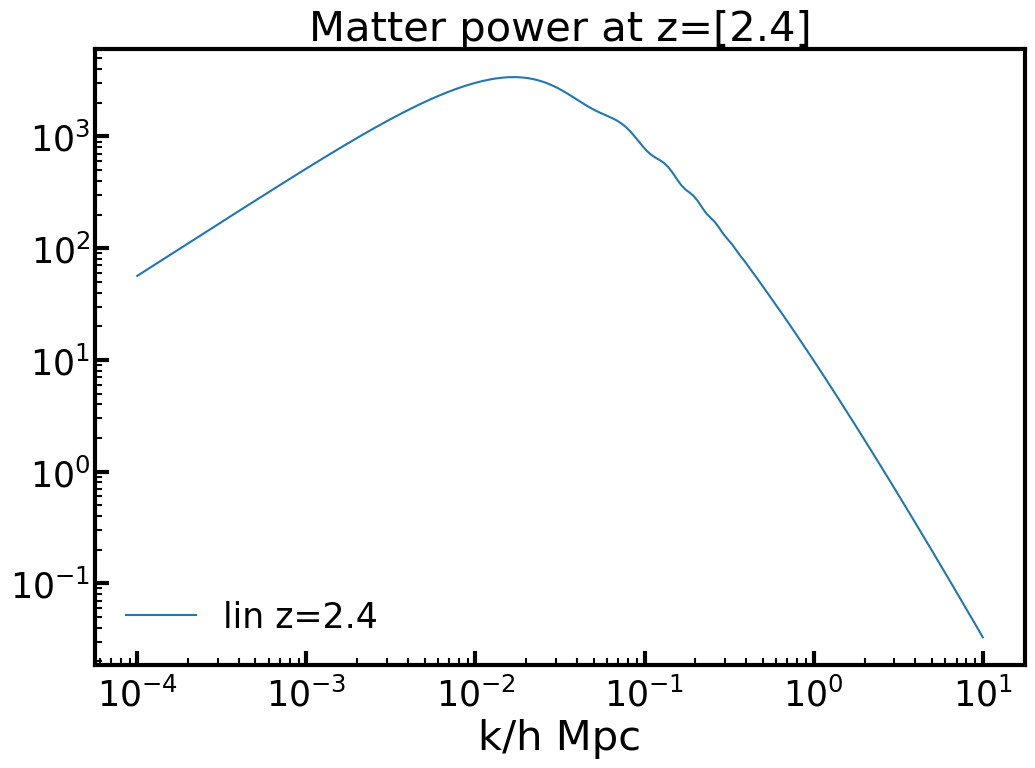

In [5]:
# Plotting the matter power spectrum at different redshifts
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], ls = line)

# Adding labels and legend to the plot
plt.xlabel('k/h Mpc')
plt.legend(['lin z={:1.1f}'.format(z[0]), 'nbodykit Plin'], loc='lower left')
plt.title('Matter power at z=%s' % z)


## Calculate Fourier modes
Here you can choose the specifics of you GRFs

In [6]:
#number of cells (relatively large to try and limit discreteness effects)
N=512 # high res

L=1380. # box size in [h^-1.Mpc] cell size*n_x
bins = 30 #number of bins in k from which the power spectrum P will be estimated

k_f=2 * np.pi/L
print('Fundamental mode k_f=',k_f)

kfft=np.fft.fftfreq(N)*2.0*np.pi/L*N # deal with frequencies corresponding to FFT 
kminfft=np.amin(np.abs(kfft)) # find min frequency (probably zero)
kmaxfft=np.amax(np.abs(kfft)) # find max frequencey (Nyquist) - can be negative
kmax=np.sqrt(3)*kmaxfft # max mode k 
print('max mode k_f=',kmax)
kmin=kminfft # min mode k 

kNy=kmaxfft; print('Nyquist frequency:', kNy) # Nyquist frequency
k_bins = np.geomspace(1.e-4,kmax,bins+1)
k_bin_ctrs=(k_bins[1:]+k_bins[:-1])/2.0

print('ratio of Nyquist to fundamental freq',kNy/k_f) # with N=128
print('ratio of max to Nyquist freq',kmax/kNy) # with np.sqrt(3) ratio

Fundamental mode k_f= 0.004553032831289555
max mode k_f= 2.0188375532346075
Nyquist frequency: 1.165576404810126
ratio of Nyquist to fundamental freq 256.0
ratio of max to Nyquist freq 1.7320508075688774


### Define power spectrum functions

In [7]:
# Function to compute the mu values for each k mode
@jit(nopython=True)
def compute_mu3d(n):
    print('compute mu = k_los / |k|')
    mu  = np.ones((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                mu[i,j,l]=kz/(1e-10+k_sum) # angle to z axis
    return mu

# Function to compute the k values for each mode
@jit(nopython=True)
def get_ks3d(L, n):
    kk  = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(n):
                kx=kfft[i]
                ky=kfft[j]
                kz=kfft[l]
                k_sum=np.sqrt(kx**2.0 + ky**2.0 + kz**2.0) # module of distance of origin to compute P(k)
                kk[i,j,l]=k_sum
    return kk

# Function to generate the amplitudes for each k mode
@jit(nopython=True)
def get_amplitudes3d(L, n, Pk, beta, mu):
    areal = np.zeros((n,n,n))
    aim = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for l in range(np.int32(n/2+1)):
            #for l in range(n):
                pk = Pk[i,j,l]
                if (i==0 or i==np.int32(n/2)) and (j==0 or j==np.int32(n/2)) and (l==0 or l==np.int32(n/2)):
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   = 0 # real value for k=0 and Nyquist frequency at i,j,l = N/2
                else:
                    areal[i,j,l] =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2)
                    aim[i,j,l]   =  np.random.normal(0., np.sqrt(pk/2.)) * ( 1. + beta * (mu[i,j,l])**2) 
                    areal[(n-i)%n][(n-j)%n][(n-l)%n] = areal[i,j,l]
                    aim[(n-i)%n][(n-j)%n][(n-l)%n]   = -aim[i,j,l]
    a = areal + 1.0j*aim
    return a #(h/Mpc)**3

# Function to compute the amplitudes for each k mode, including anisotropies
@jit(nopython=True)
def compute_amplitudes3d(L, n, Pk, bias, beta, aniso):
    print('Include anisotropies', aniso)
    if aniso:
        mu = compute_mu3d(n)
    else:
        mu  = np.zeros((n,n,n))
        beta = 0.
    print('bias', bias)
    print('beta', beta)
    print('mu', mu[:2,:2,:2].ravel())
    return bias * get_amplitudes3d(L, n, Pk, beta, mu) #(h/Mpc)**3

# Function to transform the amplitudes to a density field
def density_field(a, L, n, d=3):
    #dimension d=3
    print('Transforming amplitudes to density field')
    boxvol = float(L)**d
    pix    = (float(L)/float(n))**d
    dens   = np.fft.ifftn(a) * boxvol ** (1./2.) / pix
    #dens *= 1./np.sqrt(2*np.pi)**d
    print('dens:',np.mean(dens), np.min(dens), np.max(dens))
    #assert(np.max(abs(np.imag(dens)))<1e-10, 'Density field should be entirely real')
    return np.real(dens)

## Compute amplitudes and k 
- $P_F(k, \mu, z) = b_F(z)^2 (1+\beta_F(z)\mu^2)^2 P_{L}(k)$, thus, for the amplitudes compute $\delta_F \propto b * (\delta_m + \beta \mu^2 \delta_m)$
- We want to measure anisotropies, thus, we include the Kaiser formula
- We need to define what bias, b, and RSD parameter, $\beta$ we want

In [8]:
# choose if we want to add redshift-space distortions
add_rsd = True

# define bias and beta
my_bias = 1.
my_beta = 1.5

In [9]:
# define linear theory power spectrum for the entire box
plin = interp1d(kh_lin, pk_lin[0,:], fill_value="extrapolate")
all_ks_3d = get_ks3d(L, N)
pk_all = plin(all_ks_3d)

In [10]:
# set seed to reproduce the results
np.random.seed(100)

amplitudes_aniso       = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
amplitudes_squared   = np.real(amplitudes_aniso*np.conj(amplitudes_aniso))

#compute density field from amplitudes
dens = density_field(amplitudes_aniso, L, N)

Include anisotropies True
compute mu = k_los / |k|
bias 1.0
beta 1.5
mu [0.         0.99999998 0.         0.70710677 0.         0.70710677
 0.         0.57735026]
Transforming amplitudes to density field
dens: (-6.895798758324937e-06+0j) (-7.223163399190566+0j) (7.849698007312143+0j)


## Compute power spectrum 
- Spherically average amplitudes squared in k-shells

In [18]:
# Function to compute the power spectrum in k-shells
@jit(nopython=True)
def compute_Pk(n, amplitudes_squared):
    Phat = np.zeros(bins)  # Initialize array to store monopole power spectrum
    Phat2 = np.zeros(bins)  # Initialize array to store quadrupole power spectrum
    Phat4 = np.zeros(bins)  # Initialize array to store hexadecapole power spectrum
    k_eff = np.zeros(bins)  # Initialize array to store effective k values
    counts = np.zeros(bins)  # Initialize array to store counts of modes in each k-shell
    totcounts = 0  # Initialize total count of modes

    for i in range(n):
        for j in range(n): 
            for l in range(n):
                totcounts += 1
                kx = kfft[i]
                ky = kfft[j]
                kz = kfft[l]
                k_sum = np.sqrt(kx**2.0 + ky**2.0 + kz**2.0)  # Compute the module of distance of origin to compute P(k)
                mu = kz / (1e-10 + k_sum)  # Compute the angle to z axis
                l2mu = (3. * mu**2. - 1.) / 2.  # Compute the Legendre polynomial for quadrupole
                l4mu = (35. * mu**4. - 30. * mu**2. + 3.) / 8.  # Compute the Legendre polynomial for hexadecapole

                for m in range(bins):
                    if (k_sum >= k_bins[m] and k_sum < k_bins[m+1]):  # Check if the mode is in the k-shell
                        Phat[m] += amplitudes_squared[i, j, l]  # Measure the monopole power spectrum
                        Phat2[m] += amplitudes_squared[i, j, l] * (2. * 2. + 1.) * l2mu  # Measure the quadrupole power spectrum
                        Phat4[m] += amplitudes_squared[i, j, l] * (2. * 4. + 1.) * l4mu  # Measure the hexadecapole power spectrum
                        k_eff[m] += k_sum
                        counts[m] += 1.

    # Normalize the power spectra by the number of modes in each k-shell
    Phat /= counts
    Phat2 /= counts
    Phat4 /= counts
    k_eff /= counts

    print(sum(counts))
    print(totcounts)
    print(N**3)

    return k_eff, Phat, Phat2, Phat4, counts, totcounts


In [12]:
# compute power spectra
k_eff_tot, Phat_tot, Phat2_tot,Phat4_tot, counts,totcounts = compute_Pk(N, amplitudes_squared)

134217726.0
134217728
134217728


## compute theory

In [13]:
def get_multipoles(bias, beta, pk):
    # monopole
    p0 = bias**2 * (1. + 2.*beta/3. + beta**2. / 5. ) * pk
    # quadrupole
    p2 = bias**2 * (4.*beta/3. + 4.*beta**2. / 7.) * pk
    # hexadecapole
    p4 = bias**2 * (8. * beta**2. / 35.) * pk
    return p0, p2, p4

In [14]:
# theory power spectrum anisotropic --> beta = my_beta
p0, p2, p4             = get_multipoles(bias=my_bias, beta=my_beta, pk=pk_lin[0,:])

# compare theory to measurement

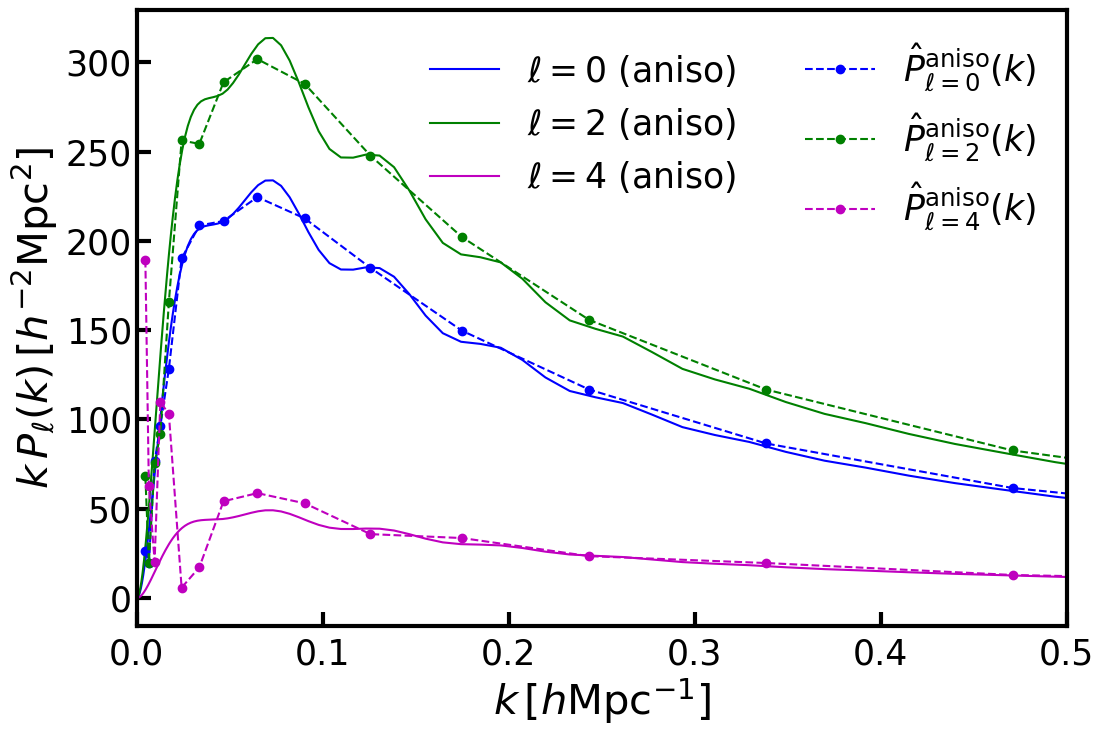

In [15]:
# Plotting the monopole, quadrupole, and hexadecapole power spectra
plt.plot(kh_lin, kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
plt.plot(kh_lin, kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
plt.plot(kh_lin, kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')

# Plotting the measured power spectra
plt.plot(k_eff_tot, k_eff_tot*Phat_tot, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat2_tot), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
plt.plot(k_eff_tot, k_eff_tot*abs(Phat4_tot), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')

# Adding labels and legends to the plot
plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.legend(ncol=2)
plt.xlim(0., 0.5)
#plt.ylim(0., 320)

# Display the plot
plt.show()

# Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- We just use a small number of skewers here for testing

In [16]:
coords = np.meshgrid(*[np.linspace(0,L,N) for _ in range(3)])
Nskew = int(1e3)
inds = np.unique(np.random.randint(0,N,size=(Nskew,2)),axis=0)
Nskew = len(inds)
print("N_skew = %d / %d"%(Nskew,N**2))

# DELTA + 1
skewer_field = 1.+dens[inds[:,0],inds[:,1],:].ravel()

# take skewers in z-direction
shift = 5e+4
print("Displacing box by %.3e"%shift)
all_x = coords[0][inds[:,0],inds[:,1],:].ravel()
all_y = coords[1][inds[:,0],inds[:,1],:].ravel()
all_z = coords[2][inds[:,0],inds[:,1],:].ravel()+shift
all_tid = (np.ones(N)[None,:]*np.arange(len(inds))[:,None]).ravel()
all_w_rand = np.ones_like(all_x,dtype='float')
all_w_gal  = np.asarray(skewer_field,dtype='float')
all_hpx = np.zeros_like(all_x,dtype='float')

N_skew = 998 / 262144
Displacing box by 5.000e+04


## apply here your own survey geometry / mask / holes etc 
$\dots$

## Plot distribution of weights

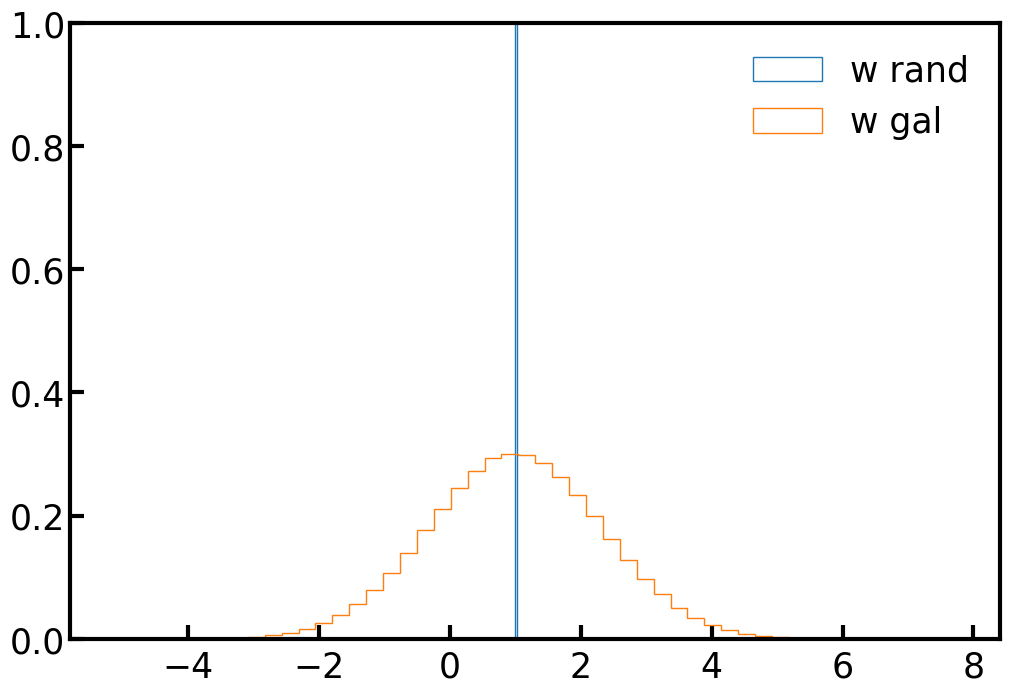

In [17]:
plt.hist(all_w_rand,density=True,histtype='step', bins=50, label='w rand');
plt.hist(all_w_gal,density=True, histtype='step',bins=50, label='w gal');
plt.ylim(0., 1);plt.legend()
plt.show()

## Remove periodicty of the box 
- to test if HIPSTER-lya is running on `real data` as well

In [19]:
remove_periodic_box = True
if remove_periodic_box:
    all_x = np.concatenate((all_x, np.array([-10., L+30.])))
    all_y = np.concatenate((all_y, np.array([-52., L+120.])))
    all_z = np.concatenate((all_z, np.array([-3., L+30.])))
    all_w_rand = np.concatenate((all_w_rand, np.array([0, 0])))
    all_w_gal  = np.concatenate((all_w_gal, np.array([0, 0])))
    all_tid    = np.concatenate((all_tid, np.array([all_tid.max()+1, all_tid.max()+2])))
    all_hpx    = np.concatenate((all_hpx, np.array([0,0])))

In [20]:
all_x.max(), all_y.max(), all_z.max()

(1410.0, 1500.0, 51380.0)

## Visually check if skewers are taken through box

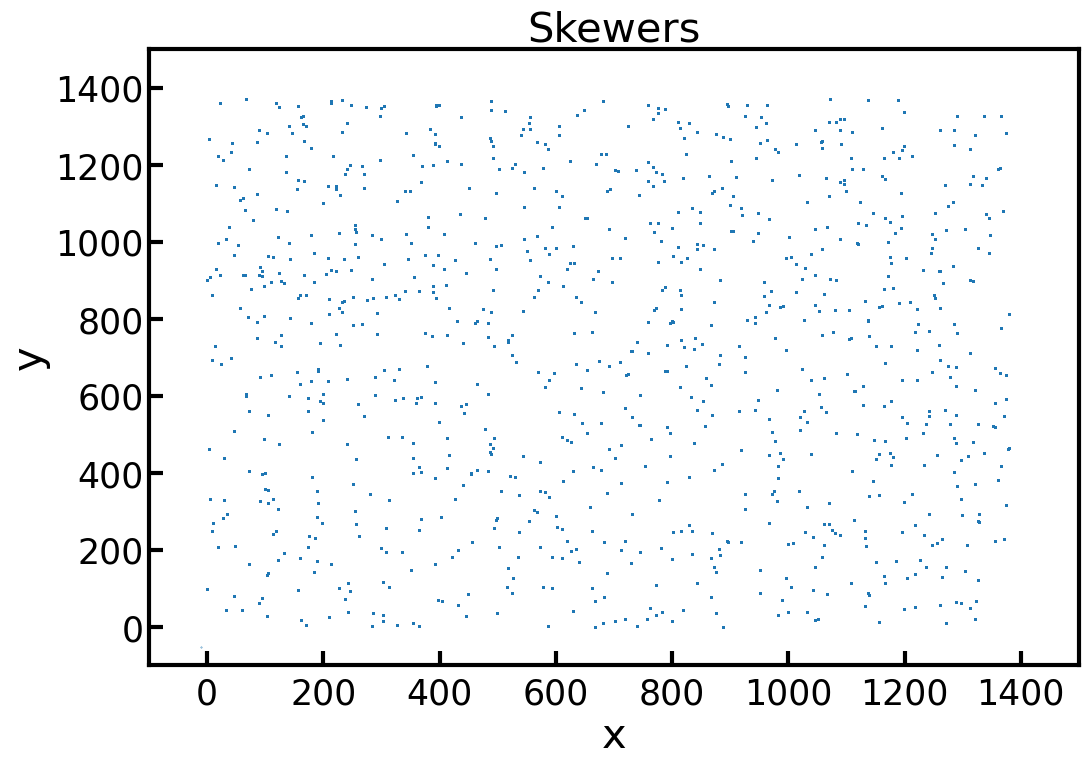

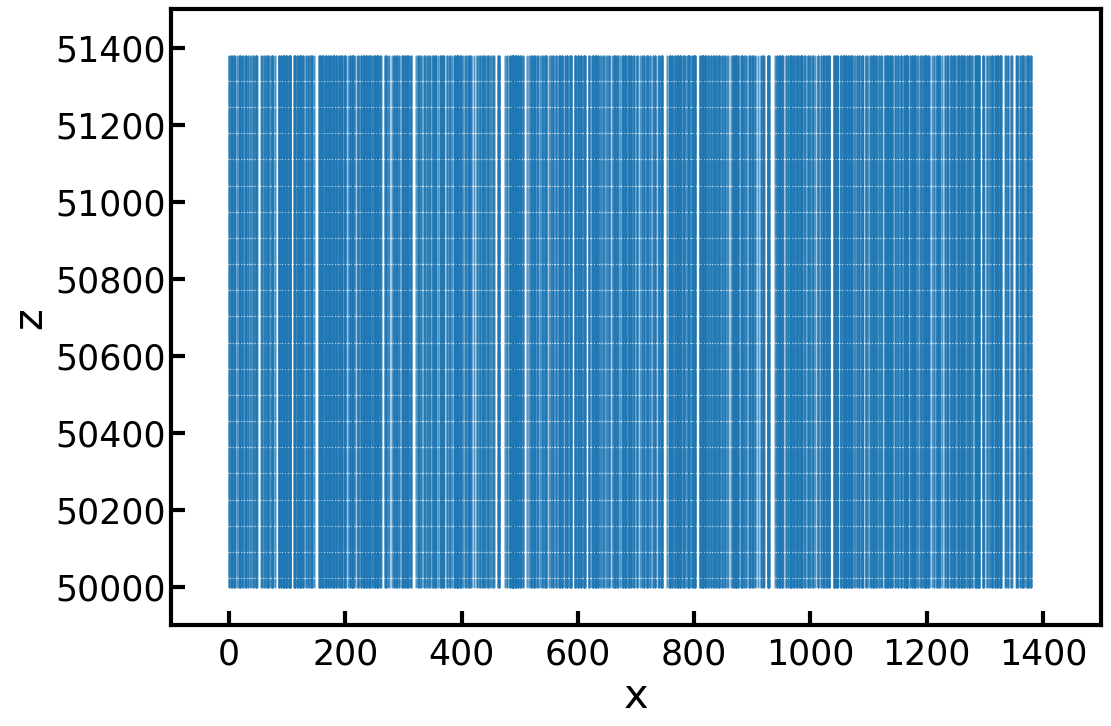

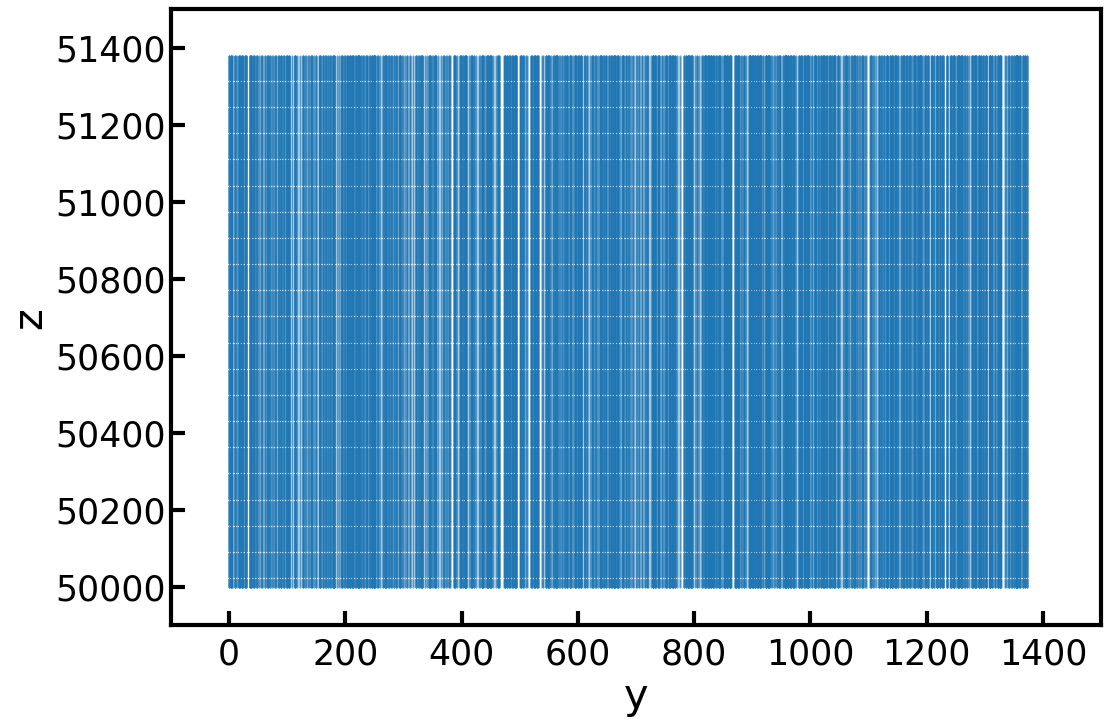

In [21]:
plt.title('Skewers')
plt.scatter(all_x[:],all_y[:],s=0.1);plt.xlabel('x');plt.ylabel('y');plt.xlim(-100, 1500);plt.ylim(-100, 1500);plt.show()
plt.scatter(all_x[:],all_z[:],s=0.1);plt.xlabel('x');plt.ylabel('z');plt.xlim(-100, 1500);plt.ylim(-100+shift, 1500+shift);plt.show()
plt.scatter(all_y[:],all_z[:],s=0.1);plt.xlabel('y');plt.ylabel('z');plt.xlim(-100, 1500);plt.ylim(-100+shift, 1500+shift);plt.show()

# Save dataset
- now we need to define our directories where to save the data

In [22]:
save_file = False
Nsim=100 # number of sims
# define directory
indir = HIPSTER_DIR

In [23]:

if save_file:
    data_name = indir+'data_skewers_unif_aperiodic_Ncell{:.0f}_Nskew{:.0f}_L{:.0f}.xyzwrwgth.sub-delta'.format(N,Nskew,L)
    print("Writing to file %s:"%data_name)
    # Now write to file:
    with open(data_name,"w+") as outfile:
        for p in range(all_w_gal.size):
            outfile.write("%.8f %.8f %.8f %.8f %.8f %.8f %.8f\n" %(all_x[p],
                                                                all_y[p],
                                                                all_z[p],
                                                                all_w_rand[p],
                                                                all_w_gal[p],
                                                                all_tid[p],
                                                                all_hpx[p]))
    print("Output positions (of length %d) written succesfully!"%all_w_gal.size)

    for seed in range(Nsim):

        np.random.seed(seed)
        amplitudes         = compute_amplitudes3d(L, N, pk_all, bias=my_bias, beta=my_beta, aniso=True)
        amplitudes_squared = np.real(amplitudes*np.conj(amplitudes))
        #compute density field from amplitudes
        dens = density_field(amplitudes, L, N)

        skewer_field = 1.+dens[inds[:,0],inds[:,1],:].ravel()
        all_w_gal  = np.asarray(skewer_field,dtype='float')
        print("Writing to file %s:"%(data_name+'%d'%seed))

        # Now write to file:
        with open(data_name+'%d'%seed,"w") as outfile:
            for p in range(all_w_gal.size):
                outfile.write("%.8f %.8f %.8f %.8f %.8f %.8f\n" %(  all_x[p],
                                                                    all_y[p],
                                                                    all_z[p],
                                                                    all_w_rand[p],
                                                                    all_w_gal[p],
                                                                    all_tid[p]))
        print("Output positions (of length %d) written succesfully!"%all_w_gal.size)

        skewer_str=''
        remove_mean_skewer=True

        if remove_mean_skewer:
            skewer_str+='_removemean'
            # remove mean along LOS for each skewer
            dens -= dens.mean(2)
            
        skewer_field = 1.+dens[inds[:,0],inds[:,1],:].ravel()
        all_w_gal  = np.asarray(skewer_field,dtype='float')

        # Now write to file:
        data_name = indir+'data_skewers_unif_aperiodic_Ncell{:.0f}_Nskew{:.0f}_L{:.0f}.xyzwrwgth.sub-delta'.format(N,Nskew,L)
        print("Writing to remove mean file %s:"%(data_name+'%d'%seed))

        with open(data_name+'%d'%seed,"w") as outfile:
            for p in range(all_w_gal.size):
                outfile.write("%.8f %.8f %.8f %.8f %.8f %.8f\n" %(  all_x[p],
                                                                    all_y[p],
                                                                    all_z[p],
                                                                    all_w_rand[p],
                                                                    all_w_gal[p],
                                                                    all_tid[p]))
        print("Output positions (of length %d) written succesfully!"%all_w_gal.size)

else:
    print('not saving files')

not saving files


### Load in HIPSTER results
- These are computed with the HIPSTER Lya code, which does not include any $\Phi^{-1}$ function.

The script used to run this code is below:

In [24]:
def load_data(st, k_file, R0=R0, nbin_RR=nbin_RR, l_max=l_max, l_max_RR=l_max_RR, verbose=True, results_dir=results_dir):
    # CAREFUL CUTTING FIRST K BIN HERE 
    k_all = np.loadtxt(k_file)
    k_av = k_all.mean(axis=1)
    pk_hip = np.loadtxt(results_dir + '%s_power_spectrum_n%d_l%d_R0%d.txt' % (st, len(k_all), l_max, R0))
    RR_hip = np.loadtxt(results_dir + '%s_RR_counts_n%d_l%d_R0%d.txt' % (st, nbin_RR, l_max_RR, R0))
    
    r_all = np.arange(0., R0 + 1e-10, dr)
    r_av = 0.5 * (r_all[1:] + r_all[:-1])

    if verbose:
        print(results_dir + '%s_power_spectrum_n%d_l%d_R0%d.txt' % (st, len(k_av), l_max, R0))
        print(results_dir + '%s_RR_counts_n%d_l%d_R0%d.txt' % (st, nbin_RR, l_max_RR, R0))
        print(k_file)

    return k_all, k_av, pk_hip, r_all, r_av, RR_hip


In [25]:
pk_hip_sim = []
RR_hip_sim = []

for i in range(Nsim):
    try:
        st = f'GRF-pk-Nskew897-{i}'
        k_all, k_av, _pk_hip, r_all, r_av, _RR_hip = load_data(st, k_file, verbose=False)
        pk_hip_sim.append(_pk_hip)
        RR_hip_sim.append(_RR_hip)
    except:
        continue
nsim = len(pk_hip_sim)
print("Using %d realizations"%(len(pk_hip_sim)))

pk_hip_sim = np.array(pk_hip_sim)
RR_hip_sim = np.array(RR_hip_sim)

pk_hip_sim_mean = pk_hip_sim.mean(axis=0)
pk_hip_sim_std  = pk_hip_sim.std(axis=0)

Using 99 realizations


# inspect window matrix

In [26]:

def W_r(x):
    """Pair separation window function"""
    if x<1./2.:
        return 1.;
    elif x<3./4.:
        return 1.-8.*pow(2.*x-1.,3.)+8.*pow(2.*x-1.,4.);
    elif x<1:
        return -64.*pow(x-1.,3.)-128.*pow(x-1.,4.);
    else:
        return 0.
W_r = np.vectorize(W_r)

def rebin(y,n=1):
    """Function to reduce number of bins by a factor of 2**n"""
    x = y.copy()
    x = x[:(len(x)//2**n)*2**n].copy()
    for _ in range(n):
        x = 0.5*(x[::2]+x[1::2])
    return x

## Functions to compute normalized RR, i.e. Phi
r_rebin = lambda n: rebin(r_av, n)

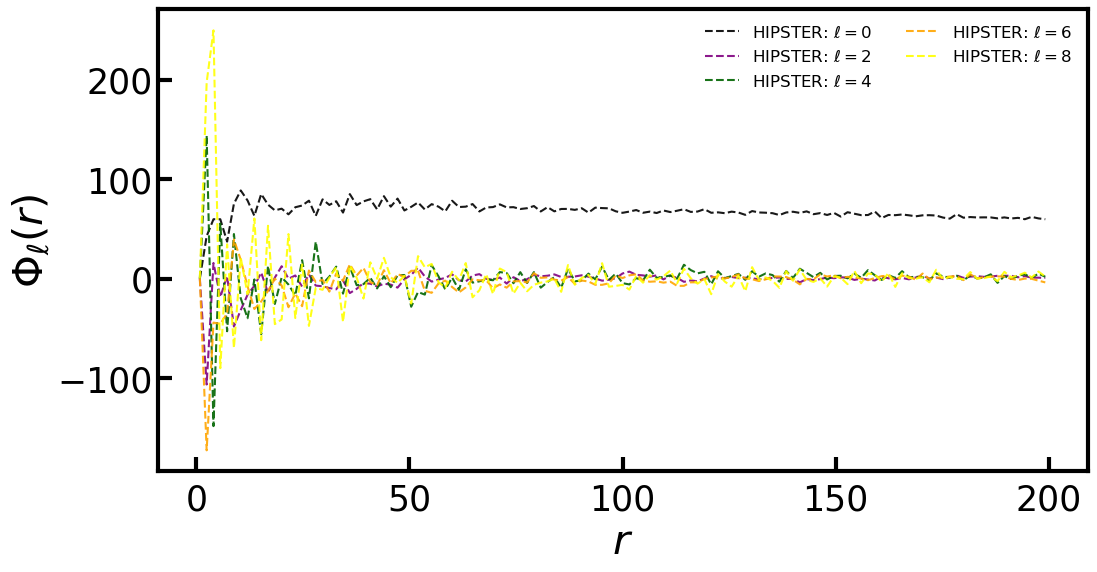

In [27]:
RR_th = 4.*np.pi/3.*(r_all[1:]**3-r_all[:-1]**3)

# Compute empirical Phi multipoles for plotting [we use explicit RR_ell(r) in theory below]
# Note that this drops a normalization term which is roughly Vol * nbar^2 * < w_rand > ^2
# RR_th = 4.*np.pi/3.*(binfile_inp[1:]**3-binfile_inp[:-1]**3)
# mu_bins = np.linspace(0.,mu_max-1./nmu_bins,nmu_bins)+0.5/nmu_bins

# Using HIPSTER
Phi0_hp_rebin = lambda n: rebin(RR_hip_sim[0,:,0],n)/rebin(RR_th,n)
Phi2_hp_rebin = lambda n: rebin(RR_hip_sim[0,:,1],n)/rebin(RR_th,n) 
Phi4_hp_rebin = lambda n: rebin(RR_hip_sim[0,:,2],n)/rebin(RR_th,n)
Phi6_hp_rebin = lambda n: rebin(RR_hip_sim[0,:,3],n)/rebin(RR_th,n)
Phi8_hp_rebin = lambda n: rebin(RR_hip_sim[0,:,4],n)/rebin(RR_th,n)


n = 3
plt.figure(figsize=(12,6))
plt.plot(r_rebin(n),Phi0_hp_rebin(n),c='k',ls='--',label=r'HIPSTER: $\ell=0$',alpha=0.9)
plt.plot(r_rebin(n),Phi2_hp_rebin(n),c='purple',ls='--',label=r'HIPSTER: $\ell=2$',alpha=0.9)
plt.plot(r_rebin(n),Phi4_hp_rebin(n),c='darkgreen',ls='--',label=r'HIPSTER: $\ell=4$',alpha=0.9)
plt.plot(r_rebin(n),Phi6_hp_rebin(n),c='orange',ls='--',label=r'HIPSTER: $\ell=6$',alpha=0.9)
plt.plot(r_rebin(n),Phi8_hp_rebin(n),c='yellow',ls='--',label=r'HIPSTER: $\ell=8$',alpha=0.9)

plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi_\ell(r)$')
plt.legend(fontsize=12,ncol=2);

### Compute integration kernels
- The theory is given by
    $$P_\ell(k) = \int 4\pi r^2 dr\,\Phi_\ell(r)\xi_0(r)W(r;R_0)K_\ell(k,r) \to \sum_i RR_{\ell,i} \xi_0(r_i)K_\ell(k,r_i)$$
in the discrete limit for radial coordinates $r_i$ and kernels $K_\ell(k, r)$. This holds ***iff*** the theory is isotropic, else there's extra $\Phi_0\xi_\ell$ etc. terms [as before].
- For thin $k$-bins, the kernel is
    $$K_\ell(k, r) = i^\ell j_\ell(kr)$$
- In practice, HIPSTER integrates the data over the $k$-bins (to reduce any oscillations, and for better compatibility with standard approaches). Thus
    $$K_\ell(k, r) = i^\ell\frac{\int_a^b k^2dk\,j_\ell(kr)}{\int_a^b k^2dk}$$
for a bin specified by $k\in[a,b)$. These integrals are analytic (as we use below). 
- Below, we compute these kernels, such that they can be applied to theory, given the $RR_\ell(r_i)$ counts.

In [28]:
# Whether to integrate theory across the k-bins (exactly)
k_integration = True
rebin_parameter = 0

In [29]:
from scipy.special import sici

def compute_sph_kernels(n, k_integration=k_integration, k_all=k_all, k_av=k_av, r_av=r_av):
    """Compute the Bessel integration kernels. These are i^ell j_ell(kr) optionally (analytically) integrated over each k-bin"""
    
    rr_av = rebin(r_av,n)
    
    sph_kernels = []
    
    if not k_integration:
        for ell in range(0,l_max-1,1):
            l=2*ell
            sph_kernels.append((1.0j)**l*spherical_jn(l,k_av[None,:]*rr_av[:,None]))
    else:
        def D_func(ell, kr):
            if l==0:
                return kr**2*spherical_jn(1,kr)
            elif l==2:
                return kr*np.cos(kr)-4.*np.sin(kr)+3.*sici(kr)[0]
            elif l==4:
                return 0.5*((105./kr-2.*kr)*np.cos(kr)+(22.-105./kr**2)*np.sin(kr)+15.*sici(kr)[0])

        for ell in np.arange(0,l_max-1,1):
            l=2*ell
            this_kernel = []
            for a in range(len(k_all)):
                kr_lo, kr_hi = k_all[a,0]*rr_av, k_all[a,1]*rr_av
                this_term = 3.*(-1.)**(l/2)*(D_func(l,kr_hi)-D_func(l,kr_lo))/(kr_hi**3-kr_lo**3)
                this_kernel.append(this_term)
            sph_kernels.append(np.asarray(this_kernel).T)

    return sph_kernels



### Assemble theory
- Now we put together the theory ingredients discussed above.
- Here, we have Corrfunc and HIPSTER theory versions; in practice, we should only use the HIPSTER version.

In [30]:
from scipy.special import spherical_jn
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline

def pnl_theory_rebin_hp(n, xi0, xi2, xi4,RR_hip, k_integration, return_xi=False):
    """Compute power spectrum multipoles with rebinning"""
    rr_av = rebin(r_av,n)
    
    # Compute Phi functions and use coarser bins optionally
    r2Phi0 = rebin(RR_hip[:,0],n)*2**n
    r2Phi2 = rebin(RR_hip[:,1],n)*2**n
    r2Phi4 = rebin(RR_hip[:,2],n)*2**n
    r2Phi6 = rebin(RR_hip[:,3],n)*2**n
    r2Phi8 = rebin(RR_hip[:,4],n)*2**n
    
    # Compute j_ell kernels
    sph_kernels = compute_sph_kernels(n,k_integration=k_integration)
    
    # truncate pair separation
    W_arr = W_r(rr_av/R0)

    # Compute xi_ell
    xinl0 = InterpolatedUnivariateSpline(rnl_theory_camb,xi0)(rr_av)*W_arr
    xinl2 = InterpolatedUnivariateSpline(rnl_theory_camb,xi2)(rr_av)*W_arr
    xinl4 = InterpolatedUnivariateSpline(rnl_theory_camb,xi4)(rr_av)*W_arr

    # monopole
    xil0_phi0 = xinl0*r2Phi0
    xil0_phi2 = xinl0*r2Phi2
    xil0_phi4 = xinl0*r2Phi4
    xil0_phi6 = xinl0*r2Phi6
    xil0_phi8 = xinl0*r2Phi8

    # quadrupole
    xil2_phi0 = xinl2*r2Phi0
    xil2_phi2 = xinl2*r2Phi2
    xil2_phi4 = xinl2*r2Phi4
    xil2_phi6 = xinl2*r2Phi6
    xil2_phi8 = xinl2*r2Phi8

    # hexadecapole
    xil4_phi0 = xinl4*r2Phi0
    xil4_phi2 = xinl4*r2Phi2
    xil4_phi4 = xinl4*r2Phi4
    xil4_phi6 = xinl4*r2Phi6
    xil4_phi8 = xinl4*r2Phi8

    # monopole
    r2xi0 = xil0_phi0 + (xil2_phi2/5.) + (xil4_phi4/9.)
    # quadrupole
    r2xi2 = xil0_phi2 + (xil2_phi0)  + (2.*xil2_phi2/7.)  + (2.*xil2_phi4/7.)  + (2.*xil4_phi2/7.)  + (100.*xil4_phi4/693.)  + (25.*xil4_phi6/143.) 
    # hexadecapole
    r2xi4 = xil0_phi4 + (18.*xil2_phi2/35.)  + (20.*xil2_phi4/77.)  + (45.*xil2_phi6/143.)  + xil4_phi0  + (20.*xil4_phi2/77.)  + (162.*xil4_phi4/1001.)  + (20.*xil4_phi6/143.)  + (490.*xil4_phi8/2431.) 

    int0 = r2xi0[:,None]*sph_kernels[0]
    int2 = r2xi2[:,None]*sph_kernels[1]
    int4 = r2xi4[:,None]*sph_kernels[2]
    
    if return_xi:
        return int0, int2, int4
    else:
        # Numerically integrate to get p_ell
        pnl0 = np.sum(int0,axis=0)
        pnl2 = np.sum(int2,axis=0)
        pnl4 = np.sum(int4,axis=0)
        
        return pnl0, pnl2, pnl4


In [31]:
p0_camb, p2_camb, p4_camb = get_multipoles(my_bias,my_beta, pk_lin[0,:])

### First compute xi0(r)
k_theory_val = np.geomspace(kh_lin.min(), kh_lin.max(), 1000)

pk_interp_theory_l0_camb = np.interp(k_theory_val,kh_lin, p0_camb)
pk_interp_theory_l2_camb = np.interp(k_theory_val,kh_lin, p2_camb)
pk_interp_theory_l4_camb = np.interp(k_theory_val,kh_lin, p4_camb)

rnl_theory_camb, xinl_theory_l0_camb = hankl.P2xi(k_theory_val, pk_interp_theory_l0_camb, l=0, n=0)
rnl_theory_camb, xinl_theory_l2_camb = hankl.P2xi(k_theory_val, pk_interp_theory_l2_camb, l=2, n=0)
rnl_theory_camb, xinl_theory_l4_camb = hankl.P2xi(k_theory_val, pk_interp_theory_l4_camb, l=4, n=0)

xinl_theory_l0_camb = np.real(xinl_theory_l0_camb)
xinl_theory_l2_camb = np.real(xinl_theory_l2_camb)
xinl_theory_l4_camb = np.real(xinl_theory_l4_camb)

In [32]:
pnl_theory_hp   = pnl_theory_rebin_hp(rebin_parameter, xi0=xinl_theory_l0_camb,xi2=xinl_theory_l2_camb,xi4=xinl_theory_l4_camb, RR_hip=RR_hip_sim[0],k_integration=k_integration)

# plot anisotropic power spectra and theory expectation for GRFs

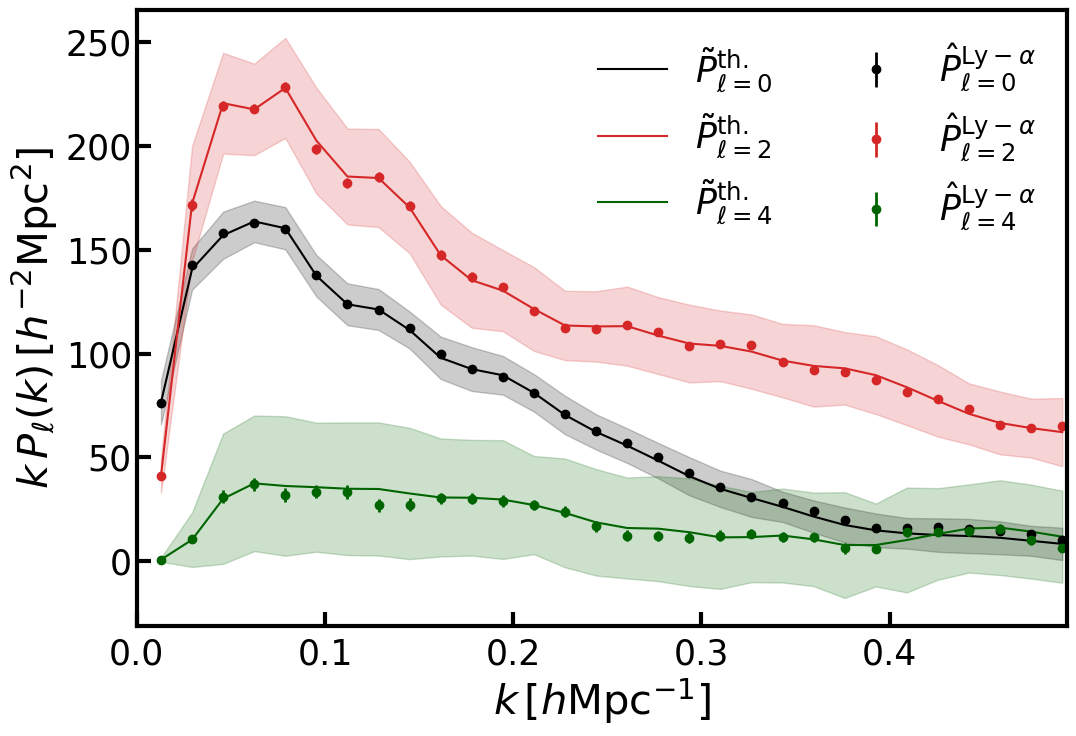

In [33]:
norm = L**3/np.sum(all_w_rand)**2.

plt.figure()

plt.fill_between(k_av, norm*k_av*(pnl_theory_hp[0] - pk_hip_sim.std(axis=0)[:,0]), 
                 norm*k_av*(pnl_theory_hp[0] + pk_hip_sim.std(axis=0)[:,0]), color='k', alpha=0.2)
plt.fill_between(k_av, norm*k_av*(pnl_theory_hp[1] - pk_hip_sim.std(axis=0)[:,1]), 
                 norm*k_av*(pnl_theory_hp[1] + pk_hip_sim.std(axis=0)[:,1]), color='C3', alpha=0.2)
plt.fill_between(k_av, norm*k_av*(pnl_theory_hp[2] - pk_hip_sim.std(axis=0)[:,2]), 
                 norm*k_av*(pnl_theory_hp[2] + pk_hip_sim.std(axis=0)[:,2]), color='darkgreen', alpha=0.2)

plt.plot(k_av, norm*k_av*pnl_theory_hp[0],  'k',         ls='-', label=r'$\tilde{P}_{\ell=0}^{\rm th.}$')
plt.plot(k_av, norm*k_av*pnl_theory_hp[1],  'C3',        ls='-', label=r'$\tilde{P}_{\ell=2}^{\rm th.}$')
plt.plot(k_av, norm*k_av*pnl_theory_hp[2],  'darkgreen', ls='-', label=r'$\tilde{P}_{\ell=4}^{\rm th.}$')

plt.errorbar(k_av, norm*k_av*pk_hip_sim_mean[:,0],yerr=k_av*norm*pk_hip_sim_std[:,0]/np.sqrt(nsim), c='k',marker='o',ls=' ',lw=2,label=r'$\hat{P}^{\mathrm{Ly}-\alpha}_{\ell=0}$')
plt.errorbar(k_av, norm*k_av*pk_hip_sim_mean[:,1],yerr=k_av*norm*pk_hip_sim_std[:,1]/np.sqrt(nsim), c='C3',marker='o',ls=' ',lw=2, label=r'$\hat{P}^{\mathrm{Ly}-\alpha}_{\ell=2}$')
plt.errorbar(k_av, norm*k_av*pk_hip_sim_mean[:,2],yerr=k_av*norm*pk_hip_sim_std[:,2]/np.sqrt(nsim), c='darkgreen',marker='o',ls=' ',lw=2,label=r'$\hat{P}^{\mathrm{Ly}-\alpha}_{\ell=4}$')


plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
plt.xlim(0., max(k_av)*1.005)
plt.legend(ncol=2)#, bbox_to_anchor=(1.,1.)
plt.show()


# compute covariance matrix 
$$\mathbf{C}_{\ell_1\ell_2}^{mn} = \frac{1}{N-1} \sum_{i=1}^N \left(\hat{P}^{m}_{\ell_1,i}(k)-\bar{P}^{m}_{\ell_1}(k)\right)\left(\hat{P}^{n}_{\ell_2,i}(k)-\bar{P}^{n}_{\ell_2}(k)\right) \ ,$$

In [34]:
def corr(mat):
    mat_copy = np.copy(mat)
    sdiag = 1. / np.sqrt(np.diag(mat_copy))
    mat_copy *= sdiag[:, np.newaxis] * sdiag[np.newaxis, :]
    return mat_copy

In [35]:
pk_hip_sim.shape

(99, 30, 3)

In [36]:
cov = np.zeros((pk_hip_sim.shape[2], pk_hip_sim.shape[1], pk_hip_sim.shape[1]))
mean_pk = np.mean(pk_hip_sim, axis=0)
nsim = pk_hip_sim.shape[0]
lidx = 0
for lidx in range(3):
    for sim_no in range(nsim):
        cov[lidx,:,:] += np.outer(pk_hip_sim[sim_no, :, lidx]-pk_hip_sim_mean[:,lidx], pk_hip_sim[sim_no, :, lidx]-pk_hip_sim_mean[:,lidx])
cov /= (nsim-1)
print(cov.shape)

(3, 30, 30)


In [37]:
cov_all = np.zeros((pk_hip_sim.shape[2],pk_hip_sim.shape[2], pk_hip_sim.shape[1], pk_hip_sim.shape[1]))
print(cov_all.shape)
mean_pk = np.mean(pk_hip_sim, axis=0)
print(mean_pk.shape)
nsim = pk_hip_sim.shape[0]
c=0
for lidx1 in range(3):
    for lidx2 in range(3):
        print(lidx1, lidx2, c)
        for sim_no in range(nsim):
            cov_all[lidx1, lidx2,:,:] += np.outer(pk_hip_sim[sim_no, :, lidx1]-pk_hip_sim_mean[:,lidx1], pk_hip_sim[sim_no, :, lidx2]-pk_hip_sim_mean[:,lidx2])
        c+=1
cov_all/=(nsim-1)
print(cov_all.shape)

(3, 3, 30, 30)
(30, 3)
0 0 0
0 1 1
0 2 2
1 0 3
1 1 4
1 2 5
2 0 6
2 1 7
2 2 8
(3, 3, 30, 30)


In [38]:
corr_cov = np.zeros((3,3, 30,30))
for i in range(3):
    for j in range(3):
        corr_cov[i,j] = cov_all[i,j,:,:]/np.sqrt(np.diag(cov_all[i,i,:,:])[:, np.newaxis]*np.diag(cov_all[j,j,:,:])[np.newaxis, :])
        #plt.imshow(corr_cov[i,j],extent=[k_av.min(), k_av.max(),k_av.min(), k_av.max()],vmin=-1, vmax=1,origin='lower', cmap='coolwarm');plt.show()

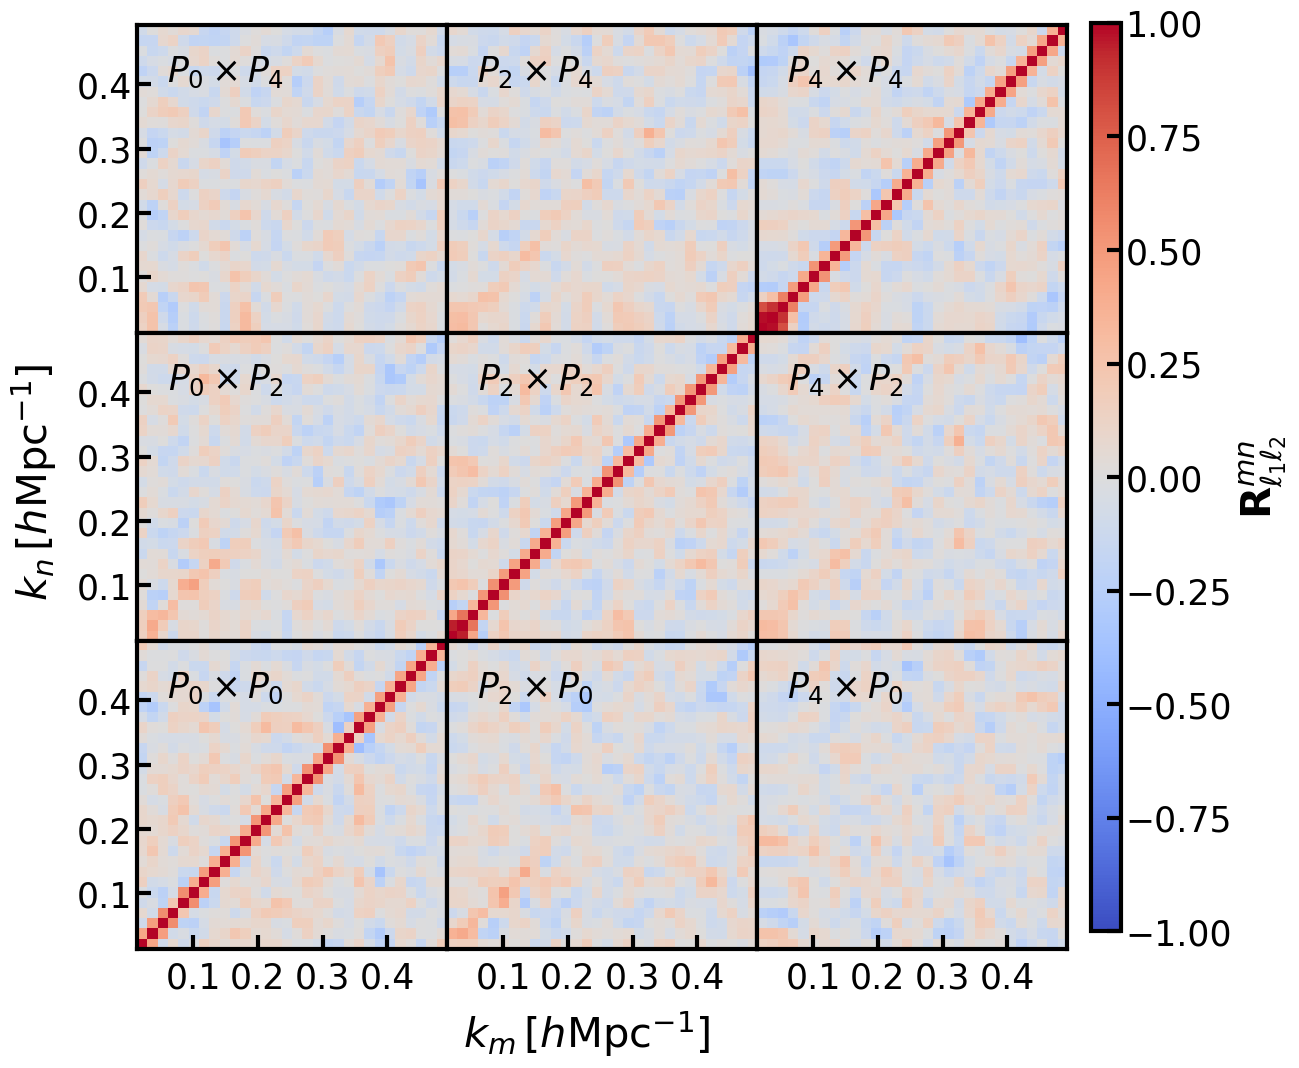

In [39]:
# Create a 9x9 grid of subplots with shared axes
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
# Loop through the subplots and plot each matrix
for i in range(3):
    for j in range(3):
        im = axes[2-i, j].imshow(corr_cov[i,j],  extent=[k_av.min(), k_av.max(),k_av.min(), k_av.max()],vmin=-1, vmax=1, cmap='coolwarm', origin='lower', aspect='auto')
        # Add a textbox with some text
        axes[2-i, j].text(0.15, 0.42, r'$P_{%s} \times P_{%s}$'%(j*2, i*2), color='black', fontsize=25, va='center', ha='center')

# Add a colorbar for the entire grid
#cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.1)
# Add a colorbar to the right of the last subplot with the same size
#fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.92, 0.125, 0.025, 0.757])  # Adjust the values as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0., pad=0.)
cbar.set_label(r'$\mathbf{R}^{mn}_{\ell_1\ell_2}$', fontsize=30)

# Set common x and y labels
fig.text(0.5, 0.04, r'$k_m\,[h$Mpc$^{-1}]$', ha='center', va='center', fontsize=30)
fig.text(0.04, 0.5, r'$k_n\,[h$Mpc$^{-1}]$', ha='center', va='center', fontsize=30, rotation='vertical')
# Set the same x and y axis ranges for all subplots
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        if i == 2:
            pass
        else:
            ax.tick_params(axis='x', bottom=False, labelbottom=False)
        if j == 0:
            pass
        else:
            ax.tick_params(axis='y', left=False, labelleft=(j == 0))
        if j > 0:
            ax.tick_params(axis='y', left=False, labelleft=False)
        ax.set_xlim(k_av.min(), k_av.max())  # Adjust the limits as needed
        ax.set_ylim(k_av.min(), k_av.max())
        ax.set_xticks(np.arange(0.1, 0.5, 0.1))
        ax.set_yticks(np.arange(0.1, 0.5, 0.1))


plt.show()


# This concludes the tutorial.